## **CNN: Text Modality using GloVe**

Se usa una arquitectura que consiste en redes neuronales convolucionales. En el paper se menciona el uso de un modelo word2vec pre-entrenado discutido en otro paper, como no se tiene acceso a este modelo se prefirió optar por otras alternativas similares pero manteniendo el uso de word2vec con 300 dimensiones.

In [1]:
import tensorflow.keras
import pandas as pd
import re

2025-12-01 06:18:28.441672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import nltk
from nltk.corpus import stopwords
import random
import torch
from torch.utils.data.dataset import random_split
from random import sample
from nltk.tokenize import word_tokenize
from collections import namedtuple

In [3]:
import gensim
from gensim.models import Word2Vec

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import numpy as np

### **Preprocesamiento**
"we preprocess them by removing stop words, non-ASCII charachters, numbers, URLs and hashtag signs. we also replace all punctuation marks with white spaces"

In [6]:
df_text = pd.read_csv('/home/jacruz/crisis/data/crisis_texts_humanitarian_dataset.csv')
df_text.head()

,tweet_id,text_human,text_human_conf,tweet_text
0,917791044158185473,other_relevant_information,1.0000,RT @Gizmodo: Wildfires raging through Northern...
1,917791130590183424,infrastructure_and_utility_damage,1.0000,PHOTOS: Deadly wildfires rage in California ht...
2,917791291823591425,other_relevant_information,0.6813,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...
3,917792092100988929,other_relevant_information,0.6727,RT @TIME: California's raging wildfires as you...
4,917792147700465664,other_relevant_information,0.7143,Wildfires Threaten Californiaâ€™s First Legal ...


In [7]:
# Para el manejo de stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['rt', 'RT'])

print(stop_words)

{'hadn', "don't", "we've", 'i', "she'd", "you'd", 'both', 'own', 'about', 'between', "he'd", 'mustn', 'very', 'each', 's', 'they', "it'd", 'their', 'after', 'hasn', "it'll", 'below', 'off', 'there', 'ma', 'for', 'against', "that'll", 'rt', 'haven', 'under', 'where', 'our', 'ain', 'here', 'than', 'shan', 'at', 'me', 'which', 'again', "they'd", 'those', 'as', 'his', 'who', 'into', "hadn't", 'can', 'herself', 't', 'some', 'with', 'my', "i've", 'and', 'her', 'are', 'its', 'that', 'been', 'on', 'out', 'few', "weren't", 'a', "i'd", 'then', 'yourselves', "shan't", "doesn't", 'up', 'the', 'yours', 'until', 'wasn', "couldn't", 'when', 'shouldn', 'further', 'to', "they're", 'were', "i'll", 'isn', "you've", "i'm", 'nor', 'all', 'more', 'other', "mightn't", 'RT', 'itself', 'these', "aren't", 'is', "he'll", 'because', 'it', 'themselves', 'weren', 'by', "we're", 'wouldn', 'this', 'has', 'if', 'or', 'most', 'yourself', 'how', 're', "we'll", 'above', 'couldn', 'don', 'such', 'what', "needn't", "hasn't

[nltk_data] Downloading package stopwords to /home/jacruz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def clean_text(text):
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Eliminar caracteres no ASCII
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Reemplazar signos de puntuación con espacios
    text = re.sub(r'[^\w\s]', ' ', text)
    # Convertir a minúsculas y eliminar stopwords
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
    return text

In [9]:
df_text['clean_text'] = df_text['tweet_text'].apply(clean_text)
df_text.head(100)

,tweet_id,text_human,text_human_conf,tweet_text,clean_text
0,917791044158185473,other_relevant_information,1.0000,RT @Gizmodo: Wildfires raging through Northern...,gizmodo wildfires raging northern california t...
1,917791130590183424,infrastructure_and_utility_damage,1.0000,PHOTOS: Deadly wildfires rage in California ht...,photos deadly wildfires rage california
2,917791291823591425,other_relevant_information,0.6813,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,cal_oes pls share capturing wildfire response ...
3,917792092100988929,other_relevant_information,0.6727,RT @TIME: California's raging wildfires as you...,time california raging wildfires never seen
4,917792147700465664,other_relevant_information,0.7143,Wildfires Threaten Californiaâ€™s First Legal ...,wildfires threaten californias first legal can...
...,...,...,...,...,...
95,917833987824979968,other_relevant_information,0.6783,Satellite image of California last night. Thos...,satellite image california last night arent li...
96,917834588814155776,affected_individuals,0.6854,RT @AuroraWorldView: Deadly #California #wildf...,auroraworldview deadly california wildfires fo...
97,917834628290920448,infrastructure_and_utility_damage,0.6667,Fire swept through Northern California early M...,fire swept northern california early monday mo...
98,917835067069788162,injured_or_dead_people,1.0000,"Couple, ages 100 and 98, die in CaliforniaÂ wi...",couple ages die california wildfire


In [10]:
# Muestra aleatoria de textos limpios
random.sample(list(df_text['clean_text']), 10)

['weather forecast issued june pm floodsl srilankafloods srilanka',
 'remember drone footage harvey usa today network bringing unique view damage irma left',
 'tattered aflyin usastrong harvey irma',
 'cried way work morning listening god bless lin manuel god bless puerto rico',
 'even dark thousands volunteers droves driven desire help mexico city earthquake victims',
 'karen_ramirez praying family amp beautiful cities mexico affected earthquake',
 'mir_sidiquee live cyclone mora kills four crossing rangamati',
 'home houston east texas needs lot help time recover help',
 'heard dad saying hates beyonc visiting harvey victims',
 'harvey terror heartbreak heroism five houstonians brave americas worststorm']

In [11]:
#dataset = tuple((row['informative'], row['clean_text']) for _, row in df_text.iterrows())
dataset = tuple(
    (row['text_human'], row['clean_text'])
    for _, row in df_text.iterrows() 
)
dataset[:5]

(('other_relevant_information',
  'gizmodo wildfires raging northern california terrifying'),
 ('infrastructure_and_utility_damage',
  'photos deadly wildfires rage california'),
 ('other_relevant_information',
  'cal_oes pls share capturing wildfire response recovery info'),
 ('other_relevant_information', 'time california raging wildfires never seen'),
 ('other_relevant_information',
  'wildfires threaten californias first legal cannabis harvest'))

In [12]:
# Muestra de labels
# Hacemos una lista de las clases
classes = df_text['text_human'].unique().tolist()

# Diccionario para mapear las clases a índices
class_mapping = {cls: idx for idx, cls in enumerate(classes)}

print(f"\n Labels para clasificación humanitaria:")
for i, label in enumerate(classes):
    print(f"{i}: {label}")

classes


 Labels para clasificación humanitaria:
0: other_relevant_information
1: infrastructure_and_utility_damage
2: injured_or_dead_people
3: not_humanitarian
4: missing_or_found_people
5: rescue_volunteering_or_donation_effort
6: affected_individuals
7: vehicle_damage


['other_relevant_information',
 'infrastructure_and_utility_damage',
 'injured_or_dead_people',
 'not_humanitarian',
 'missing_or_found_people',
 'rescue_volunteering_or_donation_effort',
 'affected_individuals',
 'vehicle_damage']

In [13]:
# Proporciones
train_ratio = 0.75
dev_ratio = 0.15
test_ratio = 0.15

# Longitudes
train_len = int(len(dataset) * train_ratio)
dev_len = int(len(dataset) * dev_ratio)
test_len = len(dataset) - train_len - dev_len  # para evitar problemas de redondeo

# Tamaño total del dataset y su distribución de clases
print(f"Tamaño total del dataset: {len(dataset)}")
# total_informative = sum(1 for label, _ in dataset if label == 'informative')
# total_non_informative = len(dataset) - total_informative
# print(f"  Informative: {total_informative} ({total_informative / len(dataset) * 100:.2f}%)")
# print(f"  Non-informative: {total_non_informative} ({total_non_informative / len(dataset) * 100:.2f}%)")

# Dividimos el dataset
train_split, dev_split, test_split = random_split(dataset, [train_len, dev_len, test_len])

# Mostramos los tamaños de cada split y su distribución de clases
print(f"\nTamaño del set de entrenamiento: {len(train_split)}")
# train_informative = sum(1 for label, _ in train_split if label == 'informative')
# train_non_informative = len(train_split) - train_informative
# print(f"  Informative: {train_informative} ({train_informative / len(train_split) * 100:.2f}%)")
# print(f"  Non-informative: {train_non_informative} ({train_non_informative / len(train_split) * 100:.2f}%)")

print(f"Tamaño del set de validación: {len(dev_split)}")
# dev_informative = sum(1 for label, _ in dev_split if label == 'informative')
# dev_non_informative = len(dev_split) - dev_informative
# print(f"  Informative: {dev_informative} ({dev_informative / len(dev_split) * 100:.2f}%)")
# print(f"  Non-informative: {dev_non_informative} ({dev_non_informative / len(dev_split) * 100:.2f}%)")

print(f"Tamaño del set de prueba: {len(test_split)}")
# test_informative = sum(1 for label, _ in test_split if label == 'informative')
# test_non_informative = len(test_split) - test_informative
# print(f"  Informative: {test_informative} ({test_informative / len(test_split) * 100:.2f}%)")
# print(f"  Non-informative: {test_non_informative} ({test_non_informative / len(test_split) * 100:.2f}%)")

# Mostramos algunos ejemplos
print("\nEjemplos del set de entrenamiento:")
for example in sample(list(train_split), 3):
    print(example)
print("\nEjemplos del set de validación:")
for example in sample(list(dev_split), 3):
    print(example)
print("\nEjemplos del set de prueba:")
for example in sample(list(test_split), 3):
    print(example)

Tamaño total del dataset: 16058

Tamaño del set de entrenamiento: 12043
Tamaño del set de validación: 2408
Tamaño del set de prueba: 1607

Ejemplos del set de entrenamiento:
('other_relevant_information', 'tropical cyclone mora barreled bangladesh earlier week get story')
('other_relevant_information', 'drone footage mexico city earthquake quadcopters uav dronefans')
('other_relevant_information', 'insurance industry preparation hurricane irma full swing florida insurance pdx')

Ejemplos del set de validación:
('other_relevant_information', 'said irma helps count calories nothing buy still')
('other_relevant_information', 'man global warming real harvey irma jose katia')
('not_humanitarian', 'hurricane harvey destroyed signed copy lenadunham kind girl ddd')

Ejemplos del set de prueba:
('rescue_volunteering_or_donation_effort', 'thank neil fenton fespa uk ceo support earthquake mexico fespa mxico rocks c fespamexico')
('not_humanitarian', 'mab mora sisters rip')
('not_humanitarian', 'j

In [14]:
document = namedtuple('tweet', ['text', 'label'])

tokenized_train_set = [document(text=word_tokenize(d[1]), label=d[0]) for d in train_split]
train_set = pd.DataFrame(tokenized_train_set)

tokenized_dev_set = [document(text=word_tokenize(d[1]), label=d[0]) for d in dev_split]
dev_set = pd.DataFrame(tokenized_dev_set)

tokenized_test_set = [document(text=word_tokenize(d[1]), label=d[0]) for d in test_split]
test_set = pd.DataFrame(tokenized_test_set)

test_set.head()


,text,label
0,"[brave, heroic, dog, saves, mexico, earthquake...",rescue_volunteering_or_donation_effort
1,"[mdblanchfield, green, energy, giants, want, p...",not_humanitarian
2,"[inside, aspca, emergency, shelter, ee, animal...",rescue_volunteering_or_donation_effort
3,"[texas, officials, see, long, road, harvey, st...",other_relevant_information
4,"[justin, bieber, purpose, live, sanjuan, puert...",not_humanitarian


In [15]:
# Convertir etiquetas a numéricas

train_set['label'] = train_set['label'].map(class_mapping)
dev_set['label'] = dev_set['label'].map(class_mapping)
test_set['label'] = test_set['label'].map(class_mapping)

test_set.head()

,text,label
0,"[brave, heroic, dog, saves, mexico, earthquake...",5
1,"[mdblanchfield, green, energy, giants, want, p...",3
2,"[inside, aspca, emergency, shelter, ee, animal...",5
3,"[texas, officials, see, long, road, harvey, st...",0
4,"[justin, bieber, purpose, live, sanjuan, puert...",3


### **Uso de GloVe**
En el paper se usa un modelo que no es de acceso público, esta versión usa GloVe que también es pre-entrenado con Wikipedia, siendo de 300 dimensiones. Contiene aproximadamente 400K palabras. Se nota una diferencia debido a que el usado en el paper fue pre-entrenado con 364M de tweets de desastres

In [16]:
def load_glove_embeddings(glove_path, embedding_dim=300):
    """
    Carga los embeddings pre-entrenados de GloVe
    """
    print("Cargando embeddings GloVe...")
    embeddings_index = {}
    
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    print(f'Se cargaron {len(embeddings_index)} vectores de palabras.')
    return embeddings_index

In [19]:
# Descargar y cargar GloVe (versión de 300 dimensiones)
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# Cargar los embeddings GloVe
glove_path = '../informative_task/glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim=300)

Cargando embeddings GloVe...
Se cargaron 400000 vectores de palabras.


In [20]:
def create_embedding_matrix(tokenizer, glove_embeddings, embedding_dim=300, vocab_limit=50000):
    """
    Crea la matriz de embedding usando GloVe
    """
    vocab_size = min(len(tokenizer.word_index) + 1, vocab_limit)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    words_not_found = []
    words_found = 0
    
    for word, i in tokenizer.word_index.items():
        if i >= vocab_size:
            continue
        if word in glove_embeddings:
            # Palabra encontrada en GloVe
            embedding_matrix[i] = glove_embeddings[word]
            words_found += 1
        else:
            # Palabra no encontrada - usar vector aleatorio
            embedding_matrix[i] = np.random.normal(scale=0.1, size=(embedding_dim,))
            words_not_found.append(word)
    
    print(f"Palabras no encontradas en GloVe: {len(words_not_found)}")
    if len(words_not_found) > 0:
        print(f"Ejemplos de palabras no encontradas: {words_not_found[:5]}")
    
    return embedding_matrix

### **Arquitectura del modelo**

In [21]:
# Construcción del modelo 

class CNN:
    def __init__(self,
                 vocab_size,
                 embedding_matrix,
                 embedding_dim=300,
                 max_seq_len=100,
                 num_classes=2,
                 ):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.num_classes = num_classes
        self.embedding_matrix = embedding_matrix
        self.model = self.build_model()

    def build_model(self):
        input_layer = layers.Input(shape=(self.max_seq_len,))
        x = layers.Embedding(input_dim=self.vocab_size,
                                           output_dim=self.embedding_dim,
                                           weights=[self.embedding_matrix],
                                           input_length=self.max_seq_len,
                                           trainable=False)(input_layer)
        # convoluciones
        conv_blocks = []
        conv1 = layers.Conv1D(filters=100,
                              kernel_size=2,
                              activation='relu',
                              padding='same')(x)
        # Se toma el valor máximo de cada filtro
        pool1 = layers.GlobalMaxPooling1D()(conv1)
        conv_blocks.append(pool1)
        conv2 = layers.Conv1D(filters=150,
                              kernel_size=3,
                              activation='relu',
                              padding='same')(x)
        pool2 = layers.GlobalMaxPooling1D()(conv2)
        conv_blocks.append(pool2)
        conv3 = layers.Conv1D(filters=200,
                              kernel_size=4,
                              activation='relu',
                              padding='same')(x)
        pool3 = layers.GlobalMaxPooling1D()(conv3)
        conv_blocks.append(pool3)

        # concatenar las salidas de las convoluciones
        concat = layers.Concatenate()(conv_blocks)

        # dropout para evitar overfitting apagando neuronas aleatoriamente
        x = layers.Dropout(0.02)(concat)
        
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.02)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.02)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.02)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.02)(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(0.02)(x)

        # capa de salida
        output_layer = layers.Dense(self.num_classes, activation='softmax')(x)
        model = models.Model(inputs=input_layer, outputs=output_layer)
        return model
    
    def compile_model(self):
        self.model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
        return self.model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        early_stopping = [EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )]
        history = self.model.fit(X_train, y_train,
                                 validation_data=(X_val, y_val),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping])
        return history
    
    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X):
        predictions = self.model.predict(X, verbose=0)
        return predictions

### **Experimento**

In [22]:
# Preparación de los datos para Keras
X_train = [' '.join(tokens) for tokens in train_set['text']]
y_train = train_set['label'].values

X_dev = [' '.join(tokens) for tokens in dev_set['text']]
y_dev = dev_set['label'].values

X_test = [' '.join(tokens) for tokens in test_set['text']]
y_test = test_set['label'].values

# Tokenización con Keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convertir a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_dev_seq = tokenizer.texts_to_sequences(X_dev)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Parámetros
vocab_size = len(tokenizer.word_index) + 1
max_seq_len = 100
embedding_dim = 300

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post')
X_dev_pad = pad_sequences(X_dev_seq, maxlen=max_seq_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post')

print(f"Tamaño del vocabulario: {vocab_size}")
print(f"Forma de X_train: {X_train_pad.shape}")
print(f"Forma de X_dev: {X_dev_pad.shape}")
print(f"Forma de X_test: {X_test_pad.shape}")

Tamaño del vocabulario: 18648
Forma de X_train: (12043, 100)
Forma de X_dev: (2408, 100)
Forma de X_test: (1607, 100)


In [23]:
# Matriz de embedding
embedding_matrix = create_embedding_matrix(tokenizer, glove_embeddings, vocab_limit=50000, embedding_dim=300)
print(f"Forma de la matriz de embedding: {embedding_matrix.shape}")

Palabras no encontradas en GloVe: 5534
Ejemplos de palabras no encontradas: ['hurricanemaria', 'hurricaneharvey', 'puertorico', 'mexicoearthquake', 'hurricaneirma']
Forma de la matriz de embedding: (18648, 300)


In [24]:
# Instanciar y compilar el modelo
cnn_model = CNN(vocab_size=vocab_size, 
                embedding_matrix=embedding_matrix,
                embedding_dim=embedding_dim,
                max_seq_len=max_seq_len,
                num_classes=2)

model = cnn_model.compile_model()
print("Resumen del modelo:")
model.summary()

# Entrenar el modelo
print("\nIniciando entrenamiento...")
history = cnn_model.train(
    X_train_pad, y_train,
    X_dev_pad, y_dev,
    epochs=10,
    batch_size=32
)

/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1764580783.985805 2348667 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1008 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:05:00.0, compute capability: 8.6
I0000 00:00:1764580783.986211 2348667 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5479 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:08:00.0, compute capability: 8.6


Resumen del modelo:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 300)  │  5,594,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 100)  │     60,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 150)  │    135,150 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 200)  │    240,200 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 150)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 450)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 450)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    230,912 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │         66 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 6,435,388 (24.55 MB)

 Trainable params: 840,988 (3.21 MB)

 Non-trainable params: 5,594,400 (21.34 MB)


Iniciando entrenamiento...
Epoch 1/10


2025-12-01 06:19:46.275942: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f9860012bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-01 06:19:46.275956: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-12-01 06:19:46.275959: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-12-01 06:19:46.314063: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-01 06:19:46.560739: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-01 06:19:46.796371: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not 

 38/377 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3323 - loss: nan

I0000 00:00:1764580798.692002 2349013 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3612 - loss: nan

2025-12-01 06:20:07.208027: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-01 06:20:07.208047: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-01 06:20:07.208055: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-01 06:20:07.835519: I external/l

377/377 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.3703 - loss: nan - val_accuracy: 0.3721 - val_loss: nan
Epoch 2/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3707 - loss: nan - val_accuracy: 0.3721 - val_loss: nan
Epoch 3/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3707 - loss: nan - val_accuracy: 0.3721 - val_loss: nan
Epoch 4/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3707 - loss: nan - val_accuracy: 0.3721 - val_loss: nan
Epoch 5/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3707 - loss: nan - val_accuracy: 0.3721 - val_loss: nan
Epoch 6/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3707 - loss: nan - val_accuracy: 0.3721 - val_loss: nan
Epoch 7/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3707 - loss: nan - val_accuracy: 0.3721 - val_loss: nan
Epoch 8/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3707 - loss: nan - val_accuracy: 0.3721 - val_loss: nan
Epoch 9/10
377/377 ━━━━━━━━━━━━━━

In [28]:
# Evaluar en test set
print("\n" + "="*60)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*60)
test_loss, test_accuracy = cnn_model.evaluate(X_test_pad, y_test)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Predicciones
y_pred_proba = cnn_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_proba, axis=1)

# Reporte de clasificación
print("\n" + "="*60)
print("REPORTE DE CLASIFICACIÓN")
print("="*60)
print(classification_report(y_test, y_pred, 
                          target_names=classes,
                          digits=4))


EVALUACIÓN EN CONJUNTO DE PRUEBA
Loss: nan
Accuracy: 0.3678

REPORTE DE CLASIFICACIÓN
                                        precision    recall  f1-score   support

            other_relevant_information     0.3678    1.0000    0.5378       591
     infrastructure_and_utility_damage     0.0000    0.0000    0.0000       120
                injured_or_dead_people     0.0000    0.0000    0.0000        62
                      not_humanitarian     0.0000    0.0000    0.0000       444
               missing_or_found_people     0.0000    0.0000    0.0000         3
rescue_volunteering_or_donation_effort     0.0000    0.0000    0.0000       335
                  affected_individuals     0.0000    0.0000    0.0000        50
                        vehicle_damage     0.0000    0.0000    0.0000         2

                              accuracy                         0.3678      1607
                             macro avg     0.0460    0.1250    0.0672      1607
                          weigh

/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

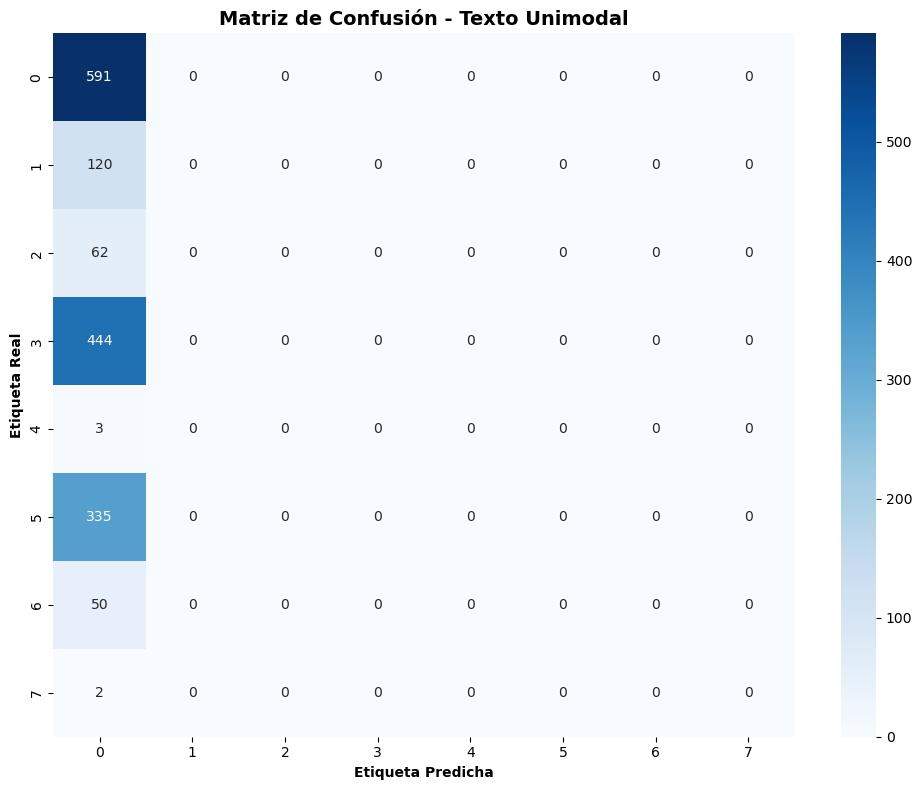

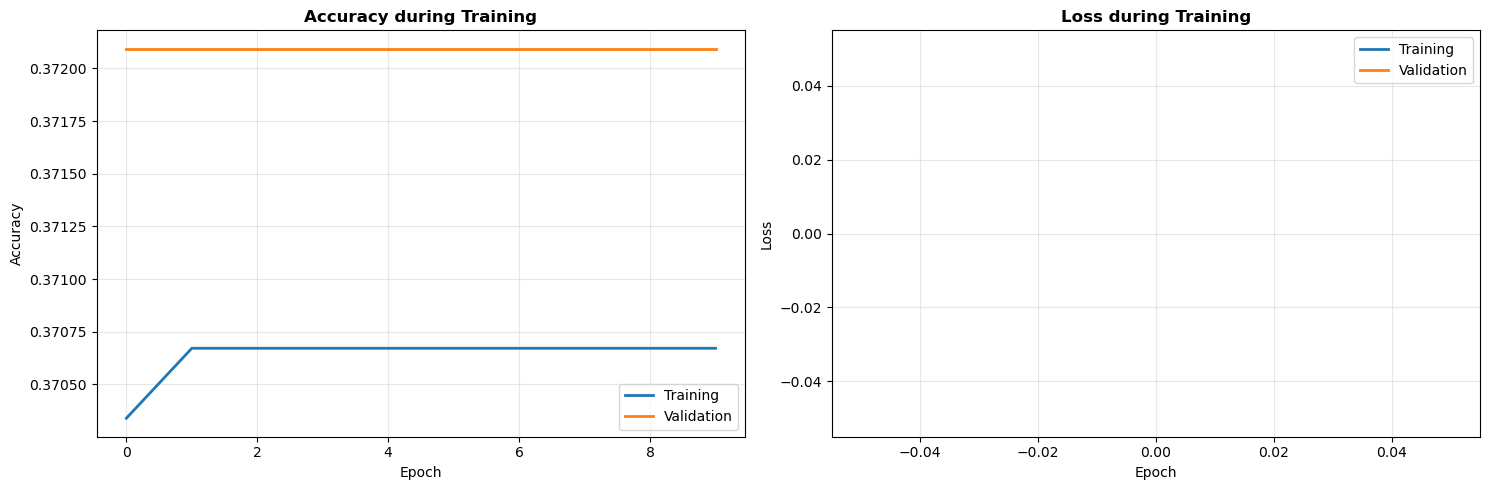

In [31]:

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Texto Unimodal', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontweight='bold')
plt.xlabel('Etiqueta Predicha', fontweight='bold')
plt.tight_layout()
plt.show()

# Curvas de aprendizaje
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.title('Accuracy during Training', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.title('Loss during Training', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:

# Calcular F1-score de nuestro modelo
# our_f1 = f1_score(y_test, y_pred)
# print(f"\nNuestro modelo - F1-score: {our_f1:.4f}")

# Estadísticas del modelo
print(f"\nEstadísticas del modelo:")
print(f"- Tamaño del vocabulario: {vocab_size}")
print(f"- Longitud máxima de secuencia: {max_seq_len}")
print(f"- Dimensión de embedding: {embedding_dim}")
print(f"- Épocas entrenadas: {len(history.history['accuracy'])}")
print(f"- Mejor exactitud en validación: {max(history.history['val_accuracy']):.4f}")

# Guardar el modelo si es necesario
model.save('text_unimodal_cnn.keras')
print("\nModelo guardado como 'text_unimodal_cnn.keras'")


Estadísticas del modelo:
- Tamaño del vocabulario: 18648
- Longitud máxima de secuencia: 100
- Dimensión de embedding: 300
- Épocas entrenadas: 10
- Mejor exactitud en validación: 0.3721

Modelo guardado como 'text_unimodal_cnn.keras'
